In [11]:
# loading required packages
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Flatten
from keras.metrics import Sum

# Oxford Pet dataset- a ResNet/UNet understanding

In [12]:
# importing oxford iii pet datasets
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2021-11-08 18:24:25.650847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-08 18:24:25.650897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-08 18:24:28.075338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-08 18:24:28.075368: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 18:24:28.078874: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RDF3FSH
2021-11-08 18:24:28.078989: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RDF3FSH
W1108 18:24:28.078227 16216 download_and_prepare.py:42] ***`tfds build` should be used instead of `downloa

INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.image_classification.oxford_iiit_pet


In [13]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [14]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\jkuhn\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [15]:
round(len(dataset['test'])*0.10)

367

In [16]:
# extract an unseen dataset from test_dataset that will not be used in training
# we will take 10% of test dataset into an unseen dataset
dataset['unseen'] = dataset['test'].take(round(len(dataset['test'])*0.10))
dataset['test'] = dataset['test'].skip(round(len(dataset['test'])*0.10))
print('test random',len(dataset['test']))
print('unseen',len(dataset['unseen']))

test random 3302
unseen 367


In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [18]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
unseen = dataset['unseen'].map(load_image_unseen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [20]:
class_names = ['pet', 'background', 'outline']

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()


def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

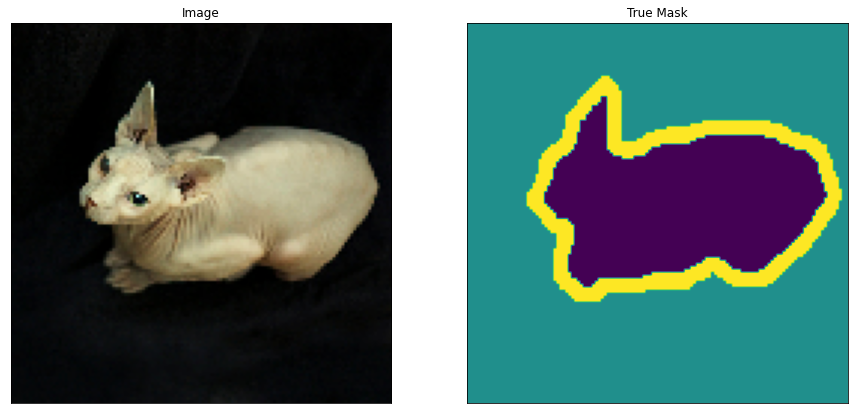

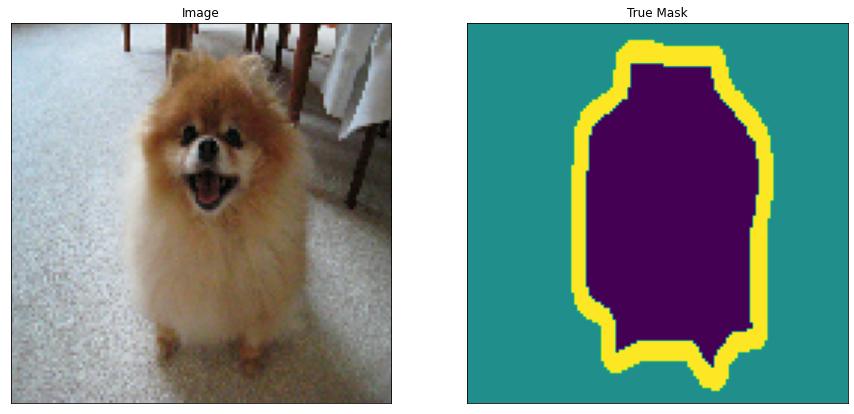

In [21]:
show_image_from_dataset(train)
show_image_from_dataset(test)

In [12]:
len(train)

3680

In [13]:
len(test)

3302

In [14]:
len(unseen)

367

# First model with simple UNet
based on https://medium.com/geekculture/semantic-image-segmentation-using-unet-28dbc247d63e

In [22]:
#UNet Encoder
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [23]:
# adding a bottleneck output
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

In [24]:
# adding a decoder

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [25]:
# creating the model

OUTPUT_CHANNELS = 3

def unet():
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))
  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model_simpleunet = unet()

model_simpleunet.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [23]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'simpleUNet_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20  # in the interest of time
VAL_SUBSPLITS=5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# get model
model_simpleunet.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])
              
model_simpleunet_history = model_simpleunet.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch = 2, #STEPS_PER_EPOCH,
                                                validation_steps = 2, #VALIDATION_STEPS,
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/20


InvalidArgumentError:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [1 1 1...] [y (confusion_matrix/Cast_2:0) = ] [2]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/else/_19/confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_10593]

Function call stack:
train_function


In [21]:
# get IOU function
def mean_iou(y_true, y_pred):
        y_pred = tf.round(tf.cast(y_pred, tf.int32))
        intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
        union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
        smooth = tf.ones(tf.shape(intersect))
        return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
%%time
import keras

#callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping(      # interupts training when improvement stops
    monitor = 'accuracy',  # monitors the model's validation accuracy
    patience = 3), # interrupts training when accuracy has stopped improving for more than 3 epoch
    keras.callbacks.ModelCheckpoint(  # saves the current weights after every epoch
    filepath = 'simpleUNet_model.h5',   # path to the destination model file
    monitor = 'val_loss',
    save_best_only = True)]   # these two arguments mean you won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20  # in the interest of time
VAL_SUBSPLITS=5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# get model
model_simpleunet.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy',mean_iou])
              
model_simpleunet_history = model_simpleunet.fit(train_dataset, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch = STEPS_PER_EPOCH,
                                                validation_steps = VALIDATION_STEPS,
                                                callbacks = callbacks_list, 
                                                validation_data=test_dataset)  

Epoch 1/20
57/57 [==============================] - 1900s 33s/step - loss: 0.8950 - accuracy: 0.6023 - mean_iou: 0.0153 - val_loss: 0.7366 - val_accuracy: 0.6979 - val_mean_iou: 0.0149
Epoch 2/20
57/57 [==============================] - 1887s 33s/step - loss: 0.7102 - accuracy: 0.7098 - mean_iou: 0.0150 - val_loss: 0.6539 - val_accuracy: 0.7323 - val_mean_iou: 0.0149
Epoch 3/20
57/57 [==============================] - 1831s 32s/step - loss: 0.6423 - accuracy: 0.7399 - mean_iou: 0.0156 - val_loss: 0.6478 - val_accuracy: 0.7340 - val_mean_iou: 0.0149
Epoch 4/20
57/57 [==============================] - 1810s 32s/step - loss: 0.5965 - accuracy: 0.7620 - mean_iou: 0.0150 - val_loss: 0.5444 - val_accuracy: 0.7843 - val_mean_iou: 0.0149
Epoch 5/20
 4/57 [=>............................] - ETA: 23:58 - loss: 0.5658 - accuracy: 0.7741 - mean_iou: 0.0165

In [ ]:
plt.plot(model_simpleunet_history.history['accuracy'])
plt.plot(model_simpleunet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_simpleunet_history.history['loss'])
plt.plot(model_simpleunet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_simpleunet_history.history['mean_iou'])
plt.plot(model_simpleunet_history.history['val_mean_iou'])
plt.title('model mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
integer_slider = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_simpleunet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

def get_test_image_and_annotation_arrays():
  ds = unseen_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()


In [ ]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
y_pred_mask = make_predictions(y_true_images[28], y_true_segments[28])

display([y_true_images[28], y_pred_mask, y_true_segments[28]], ["Image", "Predicted Mask", "True Mask"])

In [ ]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
y_pred_mask = make_predictions(y_true_images[15], y_true_segments[15])

display([y_true_images[15], y_pred_mask, y_true_segments[15]], ["Image", "Predicted Mask", "True Mask"])

In [ ]:
from matplotlib.pyplot import figure
img = np.array(y_true_images[15])
img = np.resize(img, (1,128, 128,3))
square = 5
ix = 1
feature_maps = model.predict(img)
figure(figsize=(8, 6), dpi=80)
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
# summarize feature map shapes
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
for i in range(len(model_simpleunet.layers)):
	layer = model_simpleunet.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Reshape
img = load_img(r'C:\Users\jkuhn\Documents\grad school\final_project\salt_diapirs\cat_images\cat1.jpg', target_size=(128, 128))
plt.imshow(img)
img = np.resize(img, (1,128, 128,3))

In [ ]:
pred_mask_new = model_simpleunet.predict(img)
pred_mask_new

plt.figure(figsize=(15,15))
plt.imshow(create_mask(pred_mask_new))
plt.xlabel('mask')

In [ ]:
from matplotlib.pyplot import figure
img = np.array(img)
square = 5
ix = 1
feature_maps = model.predict(img)
figure(figsize=(8, 6), dpi=80)
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
# saved model for simple UNET
model_simpleunet.save('/saved_models/simple_UNET_model')

# Salt diapir

In [59]:
# get parent dataset
parent = os.getcwd()
salt_diapir_folder = parent + r'\tgs-salt-identification-challenge'
print(parent)
print(salt_diapir_folder)
#seismic_data = 

C:\Users\jkuhn\Documents\grad school\final_project\salt_diapirs
C:\Users\jkuhn\Documents\grad school\final_project\salt_diapirs\tgs-salt-identification-challenge
